<H1><CENTER> Dstributed Machine Learning Lab - Exercise Sheet 5 <br /></CENTER></H1>
<H2><CENTER> Author: Sebastian Pineda Arango  <br />
ID: 246098<br />
Universität Hildesheim - Data Analytics Master </CENTER></H2>

<img src="https://www.uni-hildesheim.de/typo3conf/ext/unihildesheim/Resources/Public/Images/logo-uni.svgz" width="100">

## Linear regression

### Exercise 1A: Univariate Linear Regression

In this part, we will implement a simple regression function in Tensorflow that fits randomly generated data in te following way:

$x \sim unif(0, 10)$

$l \sim \mathcal{N}(0, 0.5)$

$y = 0.5x+2+l$


#### a.) Generating data

Text(0.5,1,'Generated data')

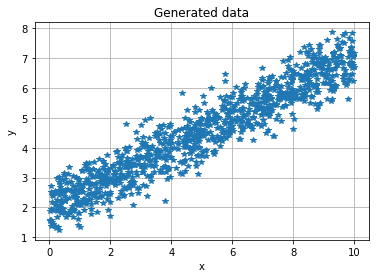

In [48]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
%matplotlib inline

#initialize variables
n = 1000
n_iterations = 1000
lr = 0.01
x = np.random.uniform( 0, 10,n)
l = np.random.normal(0, 0.5, n)

#ground truth model
y = 0.5*x + 2 + l

#plot original data
plt.plot(x, y, '*')
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated data")

#### b.) Training the model

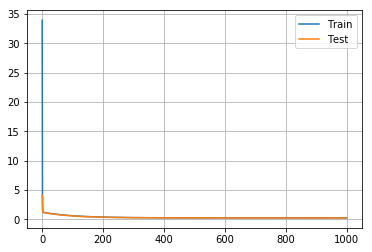

In [49]:
#splitting train and test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

#defining the graph in tensorflow
X = tf.placeholder(tf.float32, shape = (None,1))
Y = tf.placeholder(tf.float32, shape = (None,1))

W = tf.Variable(tf.truncated_normal([1, 1], stddev=0.1))
b = tf.Variable(tf.truncated_normal([1, 1], stddev=0.1))

output = tf.matmul(X,W)+b
cost =  tf.reduce_mean(tf.square(Y- output))

train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)

#initializing graph
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

#initializing list to save iteration cost
cost_train_h = []
cost_test_h = []

#training the model iteratively
for i in range(n_iterations):
    
    _, cost_train = sess.run([train_step, cost],
                       feed_dict = {X:X_train.reshape(-1,1), Y:y_train.reshape(-1,1)})
    
    cost_test = sess.run(cost,
                       feed_dict = {X:X_test.reshape(-1,1), Y:y_test.reshape(-1,1)})
    
    cost_train_h.append(cost_train)
    cost_test_h.append(cost_test)
    
plt.plot(cost_train_h)
plt.plot(cost_test_h)
plt.legend(("Train", "Test"))
plt.grid()

#### c.) Plotting final prediction

We can see, finally, that the orange line (predictions) are very close to the ground truth. We print the parameters to verify that result.

Slope: [[0.50551736]]
Intercept: [[1.9940817]]


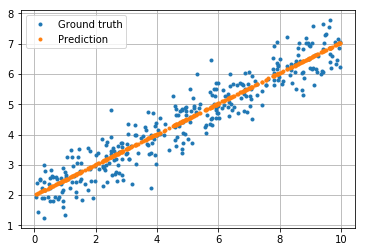

In [50]:
#plotting results
W_, b_, y_hat = sess.run([W, b, output], feed_dict = {X:X_test.reshape(-1,1), Y:y_test.reshape(-1,1)})

plt.plot(X_test, y_test, ".")
plt.plot(X_test, y_hat, ".")
plt.legend(("Ground truth", "Prediction"))
plt.grid()

print("Slope:", W_)
print("Intercept:", b_)

### Exercise 1B: Multivariate Linear Regression

We want to perform a multivariate linear regression in order to predict city-cycle fuel consumption in miles per gallon. The original data set can be found in [1], but we use a better formatted version taken from Kaggle [2].


#### Preprocessing

We read the dataset and explore the first rows. Then, we count how many missing values are there and the data type of each column.

In [67]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler

data = pd.read_csv("auto-mpg.csv")

data.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [68]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [69]:
data.apply(lambda x : type(x[0]))

mpg             <class 'float'>
cylinders         <class 'int'>
displacement    <class 'float'>
horsepower        <class 'str'>
weight            <class 'int'>
acceleration    <class 'float'>
model year        <class 'int'>
origin            <class 'int'>
car name          <class 'str'>
dtype: object

We note that horsepower is a string variable which has some values equatl to "?". We want to find out how many values there are and change them. We also want to convert the column to float data type.

In [70]:
data.apply(lambda x : np.sum(x=="?"))

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [71]:
data["horsepower"][data["horsepower"]=="?"]=0
data["horsepower"] = data["horsepower"].astype(float)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The column "car name" could be problematic, since it is a categorical variable. As we see in the following lines, this variable has 305 different values. We adopt a hash strategy where we map the "car name" into its fist 4 character (that way, for example, all car names which start with "chev" will follow in the same car name). This transormation enables to reduce the number of unique car names from 305 down to 34. 

In [72]:
len(data["car name"].unique())

305

In [73]:
len(data["car name"].apply(lambda x: x[:4]).unique())

34

Afterwards, we convert the variables into dummies ("one-hot-encoding").

In [74]:
car_dummies = pd.get_dummies(data["car name"].apply(lambda x: x[:4]))

X = pd.concat((data[data.columns[:-1]], car_dummies), 1)

In [75]:
np.array(X)

array([[ 18.,   8., 307., ...,   0.,   0.,   0.],
       [ 15.,   8., 350., ...,   0.,   0.,   0.],
       [ 18.,   8., 318., ...,   0.,   0.,   0.],
       ...,
       [ 32.,   4., 135., ...,   0.,   0.,   0.],
       [ 28.,   4., 120., ...,   0.,   0.,   0.],
       [ 31.,   4., 119., ...,   0.,   0.,   0.]])

Before training the model, we divide the data in training and test and, furthermore, we scale the data.

In [76]:
#setting the features and label columns
features = list(X.columns)
features.remove("mpg")
label = "mpg"

#selecting the label and design matrix
y = np.array(X["mpg"])
x = np.array(X[features])

#splitting train and test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

#scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (266, 41)
Test shape: (132, 41)


#### Training

We create and train the model using tensorflow. We also experiment with several leraning rates and show the comparison results.

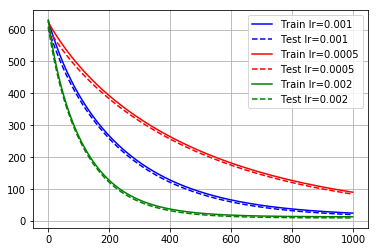

In [77]:
def regression_model (lr, n_fetures):   
    
    """Implementation of the regression model in tensorflow"""
    
    X = tf.placeholder(tf.float32, shape = (None,n_features))
    Y = tf.placeholder(tf.float32, shape = (None,1))

    W = tf.Variable(tf.truncated_normal([n_features, 1], stddev=0.1))
    b = tf.Variable(tf.truncated_normal([1, 1], stddev=0.1))

    output = tf.matmul(X,W)+b
    cost =  tf.reduce_mean(tf.square(Y- output))

    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    
    return X,Y, train_step, output, cost, W, b



def train( W, b, train_step, cost, n_iterations, plot_eval=0):

    """Training process in tensorflow"""
    
    #graph initialization
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    cost_train_h = []
    cost_test_h = []
    
    for i in range(n_iterations):

        #traininf steps
        _, cost_train = sess.run([train_step, cost],
                           feed_dict = {X:X_train_scaled, Y:y_train.reshape(-1,1)})

        cost_test = sess.run(cost,
                           feed_dict = {X:X_test_scaled, Y:y_test.reshape(-1,1)})

        cost_train_h.append(cost_train)
        cost_test_h.append(cost_test)
        
    if(plot_eval==1):
        
        #evaluation
        W_, b_, y_hat = sess.run([W, b, output], feed_dict = {X:X_test_scaled,
                                                              Y:y_test.reshape(-1,1)})

        plt.plot(y_hat, y_test, ".")
        plt.xlabel("Prediction")
        plt.ylabel("Ground Truth")
        plt.grid()        

    sess.close()

    return cost_train_h, cost_test_h

#initializing 
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_iterations = 1000
colors = ["b", "r", "g"]
lr_list = [0.001, 0.0005, 0.002]
legend= []


for lr,col in zip(lr_list, colors) :
    
    X, Y, train_step, output, cost, W, b = regression_model(lr, n_features)
    c_train, c_test = train(W, b, train_step, cost, n_iterations)
    plt.plot(c_test, col)
    plt.plot(c_train, col+"--")
    legend.append("Train lr="+str(lr))
    legend.append("Test lr="+str(lr))
    
plt.legend(legend)
plt.grid()


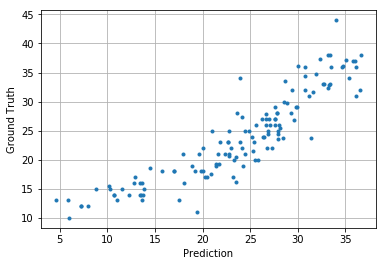

In [78]:
X, Y, train_step, output, cost, W, b = regression_model(0.02, n_features)
c_train, c_test = train( W, b, train_step, cost, 2000, plot_eval=1)

## Exercise 2: Logistic Regression on the Olivetti faces datasets points

For this task, we train a logistic regression for the Olivetti faces dataset. We following the same task proposed in [4], where the idea is to predict the lower half, given the upper half. This means, that we have a multiple output problem. In our case, we will use independent logistic regression as classifiers for every pixel prediction. Therefore, we can formulate the problem as follows:



<center>$X \space \in \space [0,1]^{N \times M}, \space W \space \in \space \mathbb{R}^{M \times M}, \space \hat{Y} \space \in \space [0,1]^{N \times M}, \space Y \space \in \space [0,1]^{N \times M}, \space b \in \space \mathbb{R}^{ M}$</center>



Here X is the flattened upper lower part of the image. The original image is $64 \times 64$, thus the lower and upper half are both of size $32  \times 64$, and the flattened image is 2048 pixels ($M=2048$). 

Therefore, we can express the prediction for a single sample (upper half) $X_n \space \in \space[0,1]^{1 \times M}$ as:

<center>$\hat{Y_n} = sigmoid(X_nW+b)$</center>

and $\space \hat{Y_n} \space \in \space [0,1]^{1 \times M}$ would be the lower half (multi-output target). We also can use the entropy loss function for this multioutput problem, which mathematically can be formulated as:


<center>$Cross Entropy=\sum_{n \in N} \sum_{m \in M}{Y_{n,m}log(\hat{Y}_{n,m}) + (1-Y_{n,m})log(1-\hat{Y}_{n,m})}$</center>

Now, we implement this idea in tensorflow and experiment with different optimizers.


In [91]:
from sklearn.datasets import fetch_olivetti_faces

# Load the faces datasets
data = fetch_olivetti_faces()
targets = data.target
data = data.images.reshape((len(data.images), -1))

#getting the numer of pixels
n_pixels = data.shape[1]

print("Data shape:", data.shape)
print("Targets shape:", targets.shape)
print("Num. of pixels:", n_pixels)

Data shape: (400, 4096)
Targets shape: (400,)
Num. of pixels: 4096


In [92]:
#splitting in train and test based on the code of [4]
train, test, targets_train, targets_test = train_test_split(
    data, targets, test_size=0.1, random_state=42)

y_train = train[:, n_pixels // 2:]
X_train = train[:, :(n_pixels + 1) // 2]
y_test = test[:, :(n_pixels + 1) // 2]
X_test = test[:, n_pixels // 2:]

n_features = X_train.shape[1]
n_output = y_train.shape[1]

In [93]:
def logistic_regression_model (lr, n_fetures, n_output, optimizer=tf.train.GradientDescentOptimizer):
    
    """Implementation of the multi-output logistic regression model"""
    
    X = tf.placeholder(tf.float32, shape = (None,n_features))
    Y = tf.placeholder(tf.float32, shape = (None,n_output))

    W = tf.Variable(tf.truncated_normal([n_features, n_output], stddev=0.1))
    b = tf.Variable(tf.truncated_normal([n_output], stddev=0.1))

    output = tf.matmul(X,W)+b
    cost =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(    labels=Y, logits=output))

    train_step = optimizer(lr).minimize(cost)
    
    return X,Y, train_step, output, cost, W, b

def train_logistic( W, b, train_step, cost, n_iterations):
    
    """Training function for logistic model"""

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    cost_train_h = []
    cost_test_h = []
    
    for i in range(n_iterations):

        _, cost_train = sess.run([train_step, cost],
                           feed_dict = {X:X_train, Y:y_train})

        cost_test = sess.run(cost,
                           feed_dict = {X:X_test, Y:y_test})

        cost_train_h.append(cost_train)
        cost_test_h.append(cost_test)
            
    W_, b_ = sess.run([W, b], feed_dict = {X:X_test, Y:y_test})
    
    sess.close()

    return W_,b_, cost_train_h, cost_test_h

Now we train the model and perform a test over a sample image. We see that the output is not perfectly similar to the ground truth, however is closed. The model could be improved with a deeper neural netowrk.

In [94]:
#Training the model
n_iterations = 200
lr = 1
X, Y, train_step, output, cost, W, b = logistic_regression_model (lr, n_features, n_output)
W, b, c_train, c_test = train_logistic(W, b, train_step, cost, n_iterations)

In [95]:
#Performing a test on a sample image
X_sample = X_train[1]
X_sample_reshaped = X_train[0].reshape((32, 64))
Y_pred = 1/(1+np.exp(-(X_sample@W+b)))
Y_pred = Y_pred.reshape((32, 64))
Y_true = y_train[1].reshape((32, 64))

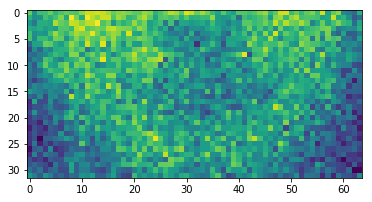

In [96]:
plt.imshow(Y_pred)

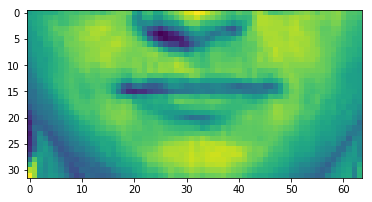

In [97]:
plt.imshow(Y_true)

Now we train using different optimizers (GradientDescent, Adam, Adagrad) and different learning rates (0.05, 0.5, 1). We see that the two latter ones improve the convergence speed.

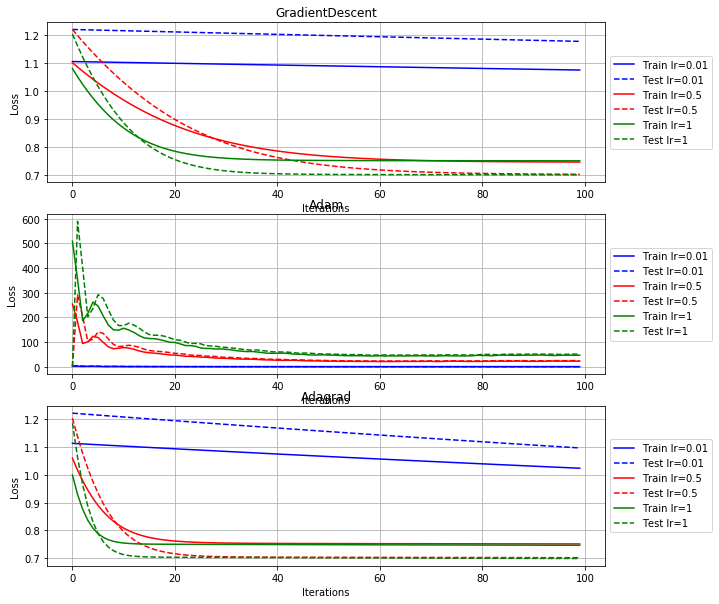

In [98]:
#initializing variables
n_iterations = 100
colors = ["b", "r", "g"]
lr_list = [0.01, 0.5, 1]
legend= []
optimizers = [tf.train.GradientDescentOptimizer, tf.train.AdamOptimizer, 
              tf.train.AdagradOptimizer]
optimizers_names =["GradientDescent", "Adam", "Adagrad"]

fig, ax = plt.subplots(len(optimizers), figsize=(10,10))

for i, opt in enumerate(optimizers):
    for lr,col in zip(lr_list, colors) :

        X, Y, train_step, output, cost, W, b =
            logistic_regression_model(lr, n_features, n_output, optimizer=opt)
        W, b, c_train, c_test = train_logistic(W, b, train_step, cost, n_iterations)
        ax[i].plot(c_test, col)
        ax[i].plot(c_train, col+"--")
        legend.append("Train lr="+str(lr))
        legend.append("Test lr="+str(lr))
    
    ax[i].legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].grid()
    ax[i].set_xlabel("Iterations")
    ax[i].set_ylabel("Loss")
    ax[i].set_title(optimizers_names[i])

## References

[1] UCI Repository: https://archive.ics.uci.edu/ml/datasets/auto+mpg

[2] Kaggle: https://www.kaggle.com/uciml/autompg-dataset/version/3

[3] Olivetti faces data set: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces

[4] Prediction of Olivetti data set for multi-output estimators: https://scikit-learn.org/stable/auto_examples/plot_multioutput_face_completion.html#sphx-glr-auto-examples-plot-multioutput-face-completion-py